# 模型构建

## 导入包

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#pd.set_option('max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [4]:
import sklearn
import math
from math import sqrt
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [5]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import (precision_score, recall_score,f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

In [7]:
def ratio_CI(r,n):
    #z = -ndtri((1.0-0.95)/2)
    z = 1.96
    upper = r+z*sqrt(r*(1-r)/n)
    upper = round(upper,4)
    lower = r-z*sqrt(r*(1-r)/n)
    lower = round(lower,4)
    return upper, lower

def confidence_interval(cm):
    Sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
    n_sens = (cm[1][1]+cm[1][0])
    Specificity = cm[0][0]/(cm[0][0]+cm[0][1])
    n_spec = (cm[0][0]+cm[0][1])
    Accuracy = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1])
    n_acc = cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1]
    
    sens_ = ratio_CI(Sensitivity,n_sens)
    spec_ = ratio_CI(Specificity,n_spec)
    acc_ = ratio_CI(Accuracy,n_spec)
    
    print('Sensitivity[CI]:%.4f [%.4f,%.4f]'%(Sensitivity,sens_[1],sens_[0]))
    print('Specificity[CI]:%.4f [%.4f,%.4f]'%(Specificity,spec_[1],spec_[0]))
    print('Accuracy[CI]:%.4f [%.4f,%.4f]'%(Accuracy,acc_[1],acc_[0]))
    print('PPV:%.4f'%(cm[1][1]/(cm[1][1]+cm[0][1])))
    print('NPV:%.4f'%(cm[0][0]/(cm[0][0]+cm[1][0])))

In [8]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [9]:
def plot_cm(labels, predictions, p=None):
    if p == None:
        p = Find_Optimal_Cutoff(labels, predictions)[0]
    else:
        p = p
    cm = confusion_matrix(labels, predictions > p)
    auc = roc_auc_score(labels,predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d",cmap = 'GnBu_r')
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label', fontsize = 12)
    plt.xlabel('Predicted label',fontsize = 12)
    
    print('True Negatives: ', cm[0][0])
    print('False totitives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True totitives: ', cm[1][1])
    print('Total: ', np.sum(cm[1]))
    print('-------------------------------')
    print('True Negatives Ratio: %s%%'%str(round((cm[0][0]/(cm[0][0]+cm[0][1]))*100,2)))
    print('False totitives Ratio: %s%%'%str(round((cm[0][1]/(cm[0][0]+cm[0][1]))*100,2)))
    print('False Negatives Ratio: %s%%'%str(round((cm[1][0]/(cm[1][1]+cm[1][0]))*100,2)))
    print('True totitives Ratio: %s%%'%str(round((cm[1][1]/(cm[1][1]+cm[1][0]))*100,2)))
    print('-------------------------------')
    print('AUC:', auc)
    print('Accuracy:', (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1]))
    print('Precision:', cm[1][1]/(cm[1][1]+cm[0][1]))
    print('F1 score', cm[1][1]/(cm[1][1]+1/2*(cm[0][1]+cm[1][0])))
    print('-------------------------------')
    print('-------------------------------')
    confidence_interval(cm)

In [11]:
dev_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('val_df.csv')

## 数据准备

In [12]:
dev_df.stay_chart_included_mdr.value_counts()

0    2111
1     277
Name: stay_chart_included_mdr, dtype: int64

In [13]:
277/(277+2111)

0.1159966499162479

In [14]:
label_features_dict = {
'stay_chart_included_mdr':['sodium',
 'RPR',
 'creatinine',
 'monocytes_abs',
 'mcv',
 'INR',
 'mchc',
 'APPT',
 'fibrinogen',
 'Temperature',
 'shock_index',
 'bilirubin',
 'D_dimer',
 'PT',
 'p',
 'gamma_GT',
 'BMI',
 'BNP',
 'PCT',
 'urea',
 'CRP',
 'ck',
 'IL_6',
 'HR',
 'los_hosp_beforeicu'
]
}

In [15]:
models_dict_lr_mod = np.load('lr_params.npy',allow_pickle=True).item()
models_dict_knn_mod = np.load('knn_params.npy',allow_pickle=True).item()
models_dict_svc_mod = np.load('svc_params.npy',allow_pickle=True).item()
models_dict_rf_mod = np.load('rf_params.npy',allow_pickle=True).item()
models_dict_xgb_mod = np.load('xgb_params.npy',allow_pickle=True).item()
models_dict_mlp_mod = np.load('mlp_params.npy',allow_pickle=True).item()

## 模型准备

In [16]:
label_names = ['stay_chart_included_mdr']

In [17]:
modelsname = []
for i in label_names:
    for j in ['_lr','_knn','_svc','_rf','_xgb','_mlp']:
        modelsname.append(i+j)

In [18]:
gramtot_lr = LogisticRegression(penalty = 'l2', C = models_dict_lr_mod['stay_chart_included_mdr']['params']['C'], random_state = 2024)

In [19]:
gramtot_knn = KNeighborsClassifier(n_neighbors = models_dict_knn_mod['stay_chart_included_mdr']['params']['n_neighbors'], \
                                       weights=models_dict_knn_mod['stay_chart_included_mdr']['params']['weights'])

In [20]:
gramtot_svc = SVC(C = models_dict_svc_mod['stay_chart_included_mdr']['params']['C'], \
                      gamma = models_dict_svc_mod['stay_chart_included_mdr']['params']['gamma'],probability = True, random_state = 2024)

In [21]:
gramtot_rf = RandomForestClassifier( max_depth = models_dict_rf_mod['stay_chart_included_mdr']['params']['max_depth'],
                                         max_features = models_dict_rf_mod['stay_chart_included_mdr']['params']['max_features'],
                                         min_samples_split = models_dict_rf_mod['stay_chart_included_mdr']['params']['min_samples_split'],
                                         n_estimators = models_dict_rf_mod['stay_chart_included_mdr']['params']['n_estimators'],
                                         random_state = 2024)

In [22]:
gramtot_rf

RandomForestClassifier(max_depth=6, max_features=0.172, n_estimators=202,
                       random_state=2024)

In [23]:
gramtot_xgb = XGBClassifier( max_depth = models_dict_xgb_mod['stay_chart_included_mdr']['params']['max_depth'],
                                         subsample = models_dict_xgb_mod['stay_chart_included_mdr']['params']['subsample'],
                                         min_child_weight = models_dict_xgb_mod['stay_chart_included_mdr']['params']['min_child_weight'],
                                         n_estimators = models_dict_xgb_mod['stay_chart_included_mdr']['params']['n_estimators'],learning_rate = 0.01,
                                         random_state = 2024)

In [24]:
gramtot_mlp = MLPClassifier(hidden_layer_sizes = (models_dict_mlp_mod['stay_chart_included_mdr']['params']['layer1'],
                                         models_dict_mlp_mod['stay_chart_included_mdr']['params']['layer2']),
                                         random_state=2024,early_stopping = False)


In [25]:
gramtot_estimators = [
    ('lr',make_pipeline(MinMaxScaler(),
                           gramtot_lr)
     ),
#     ('knn', make_pipeline(MinMaxScaler(),
#                            gramtot_knn)
#     ),
#     ('svc', gramtot_svc
#    ),
    ('rf', gramtot_rf
    ),
    ('xgb', gramtot_xgb
    ),
    ('mlp', make_pipeline(MinMaxScaler(),
                           gramtot_mlp)
    )
]

gramtot_ensemble = StackingClassifier(
     estimators=gramtot_estimators, final_estimator=LogisticRegression(solver='lbfgs', max_iter=300)
 )

In [26]:
# gramtot_mlp = MLPClassifier(early_stopping=True, hidden_layer_sizes=(55, 4),
#               random_state=2024)

In [27]:
model_list = [gramtot_lr,
gramtot_knn,
gramtot_svc,
gramtot_rf,
gramtot_xgb,
gramtot_mlp,
gramtot_ensemble]

In [28]:
modelsname_all = \
['gramtot_lr',
 'gramtot_knn',
 'gramtot_svc',
 'gramtot_rf',
 'gramtot_xgb',
 'gramtot_mlp',
 'gramtot_ensemble'
]

In [29]:
modelsname_all_prob = [i + '_prob' for i in modelsname_all]

In [30]:
def model_test(x_train,y_train,x_ext,y_ext,model):

    if (type(model) == SVC) or (type(model) == LogisticRegression) \
    or (type(model) == MLPClassifier) or (type(model) ==  KNeighborsClassifier):
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_train = pd.DataFrame(x_train)
        x_ext = pd.DataFrame(scaler.transform(x_ext))
    
    n_size = len(x_train)
    
    train = pd.concat([x_train,y_train],axis = 1)
    # run bootstrap
    stats = list()
    stats_alldata = list()
    model.fit(x_train,y_train)
    
    predict_int = model.predict_proba(x_train)
    
    predict_ext = model.predict_proba(x_ext)
    
    

    n_iterations = 5
    for i in range(n_iterations):
        # prepare train and test sets
        train_samp = resample(train, n_samples=n_size,replace= True)
        # fit model

        model.fit(train_samp.iloc[:,:-1], train_samp.iloc[:,-1])
        # evaluate model
        predictions = model.predict_proba(train_samp.iloc[:,:-1])
        
        score = roc_auc_score(train_samp.iloc[:,-1],predictions[:,1])
        #print(score)
        stats.append(score)
        
        predict_alldata = model.predict_proba(x_train)
        score_alldata = roc_auc_score(y_train,predict_alldata[:,1])
        stats_alldata.append(score_alldata)
        
    c_optimism = (np.array(stats) - np.array(stats_alldata)).mean()
    c_adjusted = roc_auc_score(y_train,predict_int[:,1]) - c_optimism
    
    # plot scores
    pyplot.hist(stats)
    pyplot.show()

    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    
    stats_mean = np.array(stats)
    print('-------------------------------------------------------------------')
    print('-------------------------------%s-------------------------------'%type(model))
    print('-------------------------------------------------------------------')
    print('训练集初始AUC：%s'%round(roc_auc_score(y_train,predict_int[:,1]),3))
    print('internal validation: bootstrap mean AUC: %.3f, 95%%CI: [%.3f - %.3f]' % (stats_mean.mean(), lower, upper))
    print('internal validation: enhanced bootstrap, over value: %.3f, AUC adjusted: %.3f' % (c_optimism, c_adjusted))
    print('-------------------------------------------------------------------')
    print('外部验证AUC：%s'%round(roc_auc_score(y_ext,predict_ext[:,1]),3))
    print('-------------------------------------------------------------------')
    
    return predict_ext[:,1]

In [31]:
def model_test_simp(x_train,y_train,x_ext,y_ext,model):

    if (type(model) == SVC) or (type(model) == LogisticRegression) \
    or (type(model) == MLPClassifier) or (type(model) ==  KNeighborsClassifier):
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_train = pd.DataFrame(x_train)
        x_ext = pd.DataFrame(scaler.transform(x_ext))
    
    n_size = len(x_train)
    
    train = pd.concat([x_train,y_train],axis = 1)
    model.fit(x_train,y_train)
    
    predict_int = model.predict_proba(x_train)
    
    predict_ext = model.predict_proba(x_ext)
    
    print('-------------------------------------------------------------------')
    print('-------------------------------%s-------------------------------'%type(model))
    print('-------------------------------------------------------------------')
    print('训练集初始AUC：%s'%round(roc_auc_score(y_train,predict_int[:,1]),3))
    print('-------------------------------------------------------------------')
    print('外部验证AUC：%s'%round(roc_auc_score(y_ext,predict_ext[:,1]),3))
    print('-------------------------------------------------------------------')
    
    return predict_ext[:,1]

In [32]:
# x_train,y_train,x_ext,y_ext = dev_df[label_features_dict['stay_chart_included_mdr']],dev_df['stay_chart_included_mdr'],\
#                val_df[label_features_dict['stay_chart_included_mdr']],val_df['stay_chart_included_mdr']

# model = MLPClassifier(early_stopping=False, hidden_layer_sizes=(80, 4),
#               random_state=2024)

# if (type(model) == SVC) or (type(model) == LogisticRegression) \
# or (type(model) == MLPClassifier) or (type(model) ==  KNeighborsClassifier):
#     scaler = MinMaxScaler()
#     x_train = scaler.fit_transform(x_train)
#     x_train = pd.DataFrame(x_train)
#     x_ext = pd.DataFrame(scaler.transform(x_ext))

# model.fit(x_train,y_train)

# predict_int = model.predict_proba(x_train)

# predict_ext = model.predict_proba(x_ext)

# roc_auc_score(y_ext,predict_ext[:,1])

# gramtot

In [33]:
gramtot_predict_dict = {}
gramtot_predict_dict['gramtot_true'] = val_df['stay_chart_included_mdr']
for i in  range(0, 7):
    print(modelsname_all_prob[i])
    gramtot_predict_dict[modelsname_all_prob[i]] = model_test_simp(dev_df[label_features_dict['stay_chart_included_mdr']],dev_df['stay_chart_included_mdr'],\
               val_df[label_features_dict['stay_chart_included_mdr']],val_df['stay_chart_included_mdr'],model_list[i])

gramtot_lr_prob
-------------------------------------------------------------------
-------------------------------<class 'sklearn.linear_model._logistic.LogisticRegression'>-------------------------------
-------------------------------------------------------------------
训练集初始AUC：0.755
-------------------------------------------------------------------
外部验证AUC：0.74
-------------------------------------------------------------------
gramtot_knn_prob
-------------------------------------------------------------------
-------------------------------<class 'sklearn.neighbors._classification.KNeighborsClassifier'>-------------------------------
-------------------------------------------------------------------
训练集初始AUC：1.0
-------------------------------------------------------------------
外部验证AUC：0.697
-------------------------------------------------------------------
gramtot_svc_prob
-------------------------------------------------------------------
-------------------------------<cl

In [34]:
gramtot_predict_dict['gramtot_true']

0       0
1       0
2       0
3       0
4       0
       ..
1143    0
1144    0
1145    0
1146    0
1147    0
Name: stay_chart_included_mdr, Length: 1148, dtype: int64

In [35]:
gramtot_predict_dict['gramtot_ensemble_prob']

array([0.05675172, 0.29379166, 0.05700284, ..., 0.1101816 , 0.09852117,
       0.06171032])

In [36]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [37]:
def confidence_interval_new(cm):
    Sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
    n_sens = (cm[1][1]+cm[1][0])
    Specificity = cm[0][0]/(cm[0][0]+cm[0][1])
    n_spec = (cm[0][0]+cm[0][1])
    Accuracy = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1])
    n_acc = cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1]
    PPV = cm[1][1]/(cm[1][1]+cm[0][1])
    n_ppv = (cm[1][1]+cm[0][1])                
    NPV = cm[0][0]/(cm[0][0]+cm[1][0])
    n_npv = (cm[0][0]+cm[1][0])
    
    acc_ = ratio_CI(Accuracy,n_spec)
    sens_ = ratio_CI(Sensitivity,n_sens)
    spec_ = ratio_CI(Specificity,n_spec)
    ppv_ = ratio_CI(PPV,n_ppv)
    npv_ = ratio_CI(NPV,n_npv)
    
    acc_str = str(round(Accuracy*100,2))+'% '+'['+str(round(acc_[1]*100,2))+'%, '+str(round(acc_[0]*100,2))+'%]'    
    sens_str = str(round(Sensitivity*100,2))+'% '+'['+str(round(sens_[1]*100,2))+'%, '+str(round(sens_[0]*100,2))+'%]' 
    spec_str = str(round(Specificity*100,2))+'% '+'['+str(round(spec_[1]*100,2))+'%, '+str(round(spec_[0]*100,2))+'%]' 
    ppv_str = str(round(PPV*100,2))+'% '+'['+str(round(ppv_[1]*100,2))+'%, '+str(round(ppv_[0]*100,2))+'%]' 
    npv_str = str(round(NPV*100,2))+'% '+'['+str(round(npv_[1]*100,2))+'%, '+str(round(npv_[0]*100,2))+'%]' 
    
    return acc_str,sens_str,spec_str,ppv_str,npv_str

In [38]:
def confidence_interval_new(cm):
    Sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
    n_sens = (cm[1][1]+cm[1][0])
    Specificity = cm[0][0]/(cm[0][0]+cm[0][1])
    n_spec = (cm[0][0]+cm[0][1])
    Accuracy = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1])
    n_acc = cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1]
    PPV = cm[1][1]/(cm[1][1]+cm[0][1])
    n_ppv = (cm[1][1]+cm[0][1])                
    NPV = cm[0][0]/(cm[0][0]+cm[1][0])
    n_npv = (cm[0][0]+cm[1][0])
    
    acc_ = ratio_CI(Accuracy,n_spec)
    sens_ = ratio_CI(Sensitivity,n_sens)
    spec_ = ratio_CI(Specificity,n_spec)
    ppv_ = ratio_CI(PPV,n_ppv)
    npv_ = ratio_CI(NPV,n_npv)
    
    acc_str = str(round(Accuracy*100,2))
    sens_str = str(round(Sensitivity*100,2))
    spec_str = str(round(Specificity*100,2))
    ppv_str = str(round(PPV*100,2))
    npv_str = str(round(NPV*100,2))
    
    return acc_str,sens_str,spec_str,ppv_str,npv_str

In [39]:
fpr, tpr, threshold = roc_curve(gramtot_predict_dict['gramtot_true'], gramtot_predict_dict['gramtot_ensemble_prob'])
cutoff_l = []
num_l = []
acc_l = []
sens_l = []
spec_l = []
ppv_l = []
npv_l = []
for i in threshold:
    gramtot_predict_dict['gramtot_ensemble_prob']>i
    test = pd.DataFrame(gramtot_predict_dict)[['gramtot_true','gramtot_ensemble_prob']]
    test['predict'] = (test['gramtot_ensemble_prob']>i).apply(int)
    cm = confusion_matrix(test['gramtot_true'], test['predict'])
    num = cm[0][1]+cm[1][1]
    acc_str,sens_str,spec_str,ppv_str,npv_str = confidence_interval_new(cm)
    
    cutoff_l.append(i)
    num_l.append(num)
    acc_l.append(acc_str)
    sens_l.append(sens_str)
    spec_l.append(spec_str)
    ppv_l.append(ppv_str)
    npv_l.append(npv_str)
    
all_cutoff = pd.DataFrame({'截断值':cutoff_l,'数量':num_l,'准确率 (%)':acc_l,'灵敏度 (%)':sens_l,'特异度 (%)':spec_l,'阳性预告值 (%)':ppv_l,'阴性预告值 (%)':npv_l})

In [40]:
num_stard = []
t = 0
for i in range(11):
    g = 1205/11
    t = g*i
    num_stard.append(t)

In [41]:
q_find = []
for i in num_stard:
    aa = []
    bb = []

    for j in all_cutoff['数量']:
        de = abs(i- j) 
        aa.append(j)
        bb.append(de)
        
    for m in range(len(bb)):
        if bb[m] == min(bb):
            find_m = m
    for s in range(len(aa)):
         q_find.append(aa[find_m])
    

In [42]:
all_cutoff[all_cutoff['数量'].isin(list(set(q_find)))].sort_values(by = '截断值').reset_index(drop = True).head(10)

,截断值,数量,准确率 (%),灵敏度 (%),特异度 (%),阳性预告值 (%),阴性预告值 (%)
0,0.054628,1094,17.25,99.32,5.29,13.25,98.15
1,0.056274,997,25.35,97.95,14.77,14.34,98.01
2,0.058482,871,35.63,95.21,26.95,15.96,97.47
3,0.061970,761,44.51,92.47,37.52,17.74,97.16
4,0.066032,668,51.22,86.99,46.01,19.01,96.04
5,0.072589,544,61.15,83.56,57.88,22.43,96.03
6,0.080705,437,69.08,78.08,67.76,26.09,95.5
7,0.096343,328,76.48,69.86,77.45,31.1,94.63
8,0.121064,218,81.18,50.68,85.63,33.94,92.26
9,0.166302,110,85.02,28.77,93.21,38.18,89.98


In [44]:
#补充f1_score

import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix, f1_score

# Assuming `confidence_interval_new` is a predefined function

fpr, tpr, thresholds = roc_curve(gramtot_predict_dict['gramtot_true'], gramtot_predict_dict['gramtot_ensemble_prob'])

cutoff_l = []
num_l = []
acc_l = []
sens_l = []
spec_l = []
ppv_l = []
npv_l = []
f1_l = []

for i in thresholds:
    test = pd.DataFrame(gramtot_predict_dict)[['gramtot_true', 'gramtot_ensemble_prob']]
    test['predict'] = (test['gramtot_ensemble_prob'] > i).apply(int)
    cm = confusion_matrix(test['gramtot_true'], test['predict'])
    num = cm[0][1] + cm[1][1]
    acc_str, sens_str, spec_str, ppv_str, npv_str = confidence_interval_new(cm)

    # Calculate F1-score
    f1 = f1_score(test['gramtot_true'], test['predict'])

    cutoff_l.append(i)
    num_l.append(num)
    acc_l.append(acc_str)
    sens_l.append(sens_str)
    spec_l.append(spec_str)
    ppv_l.append(ppv_str)
    npv_l.append(npv_str)
    f1_l.append(f1)

all_cutoff = pd.DataFrame({'截断值': cutoff_l, '数量': num_l, '准确率 (%)': acc_l, '灵敏度 (%)': sens_l,
                           '特异度 (%)': spec_l, '阳性预告值 (%)': ppv_l, '阴性预告值 (%)': npv_l, 'F1-score': f1_l})

num_stard = []
t = 0
for i in range(11):
    g = 1205 / 11
    t = g * i
    num_stard.append(t)

q_find = []
for i in num_stard:
    aa = []
    bb = []

    for j in all_cutoff['数量']:
        de = abs(i - j)
        aa.append(j)
        bb.append(de)

    find_m = bb.index(min(bb))
    q_find.append(aa[find_m])

result = all_cutoff[all_cutoff['数量'].isin(list(set(q_find)))].sort_values(by='截断值').reset_index(drop=True).head(10)
print(result)

        截断值    数量 准确率 (%) 灵敏度 (%) 特异度 (%) 阳性预告值 (%) 阴性预告值 (%)  F1-score
0  0.054628  1094   17.25   99.32    5.29     13.25     98.15  0.233871
1  0.056274   997   25.35   97.95   14.77     14.34     98.01  0.250219
2  0.058482   871   35.63   95.21   26.95     15.96     97.47  0.273353
3  0.061970   761   44.51   92.47   37.52     17.74     97.16  0.297685
4  0.066032   668   51.22   86.99   46.01     19.01     96.04  0.312039
5  0.072589   544   61.15   83.56   57.88     22.43     96.03  0.353623
6  0.080705   437   69.08   78.08   67.76     26.09      95.5  0.391081
7  0.096343   328   76.48   69.86   77.45      31.1     94.63  0.430380
8  0.121064   218   81.18   50.68   85.63     33.94     92.26  0.406593
9  0.166302   110   85.02   28.77   93.21     38.18     89.98  0.328125


True Negatives:  744
False totitives:  258
False Negatives:  39
True totitives:  107
Total:  146
-------------------------------
True Negatives Ratio: 74.25%
False totitives Ratio: 25.75%
False Negatives Ratio: 26.71%
True totitives Ratio: 73.29%
-------------------------------
AUC: 0.7861742268886884
Accuracy: 0.7412891986062717
Precision: 0.29315068493150687
F1 score 0.4187866927592955
-------------------------------
-------------------------------
Sensitivity[CI]:0.7329 [0.6611,0.8046]
Specificity[CI]:0.7425 [0.7154,0.7696]
Accuracy[CI]:0.7413 [0.7142,0.7684]
PPV:0.2932
NPV:0.9502


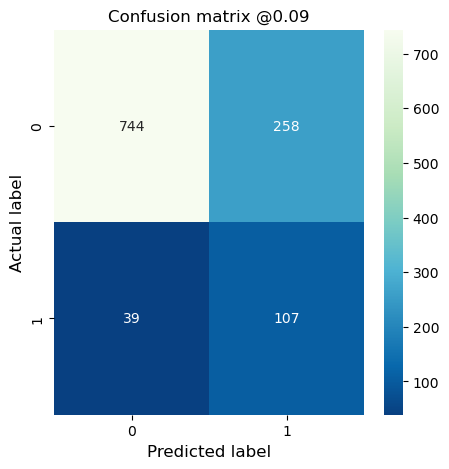

In [38]:
plot_cm(gramtot_predict_dict['gramtot_true'],gramtot_predict_dict['gramtot_ensemble_prob'])

plt.savefig('results/cm_plot.pdf',format = 'pdf',bbox_inches = 'tight', dpi = 500)

# shap

In [45]:
import shap
import time
shap.initjs()

In [46]:
x_train_tot = dev_df[label_features_dict['stay_chart_included_mdr']]

y_train_tot = dev_df['stay_chart_included_mdr']


x_val_tot = val_df[label_features_dict['stay_chart_included_mdr']]

y_val_tot = val_df['stay_chart_included_mdr']

In [47]:
gramtot_rf.fit(x_train_tot, y_train_tot)

RandomForestClassifier(max_depth=6, max_features=0.172, n_estimators=202,
                       random_state=2024)

In [48]:
explainer_tot = shap.Explainer(gramtot_rf)

shap_values_tot = explainer_tot.shap_values(x_val_tot)

In [49]:
(x_train_tot['urea']*2.8).describe()

count    2388.000000
mean       21.560575
std        17.669954
min         2.940000
25%        11.676000
50%        15.764000
75%        23.828000
max       167.916000
Name: urea, dtype: float64

In [50]:
x_val_tot.columns

Index(['sodium', 'RPR', 'creatinine', 'monocytes_abs', 'mcv', 'INR', 'mchc',
       'APPT', 'fibrinogen', 'Temperature', 'shock_index', 'bilirubin',
       'D_dimer', 'PT', 'p', 'gamma_GT', 'BMI', 'BNP', 'PCT', 'urea', 'CRP',
       'ck', 'IL_6', 'HR', 'los_hosp_beforeicu'],
      dtype='object')

In [51]:
NAME_RE_DICT = {
 'lactate':'serum lactate',

 'urea':'serum urea',
 'chloride':'serum chloride',
 'spo2':'SpO$\mathregular{_2}$',
 
 'AGE':'age',
 'before_adm_90d':'previous hospital admission within 90d',
 'charlson_comorbidity_index':'charlson comorbidity index',
 'los_hosp_beforeicu':'days of hospital stay before ICU admission',
 'chronic_pulmonary_disease':'chronic pulmonary disease',
 'creatinine':'serum creatinine',
 'hemoglobin':'hemoglobin',
 'inr':'INR',
 'icustay_rank':'No. of ICU admissions',
 'bicarbonate':'bicarbonate',
 'hospstay_seq':'No. of hospital admissions',
 'dbp':'DBP',
 'gender':'gender.Male',
 'sodium':'serum sodium',
 'Temperature':'temperature',
'D_dimer':'D-dimer',
 'basophils_abs':'absolute basophil count',
 'monocytes_abs':'absolute monocyte count',
 'lymphocytes_abs':'absolute lymphocyte count',
'eosinophil_abs':'absolute eosinophil count',
 'neutrophils_abs':'absolute neutrophil count',
    
 'mch':'MCH',
 'mchc':'MCHC',

 'glucose':'glucose',
 'wbc':'WBC',
 'platelet':'platelet',
 'resp_rate':'RR',
 'calcium':'serum calcium',
 'mcv':'MCV',
 'potassium':'serum potassium',
 'shock_index':'shock index',
 'aniongap':'aniongap',
 'rdw':'RDW',
 'gamma_GT':'GGT',
 'IL_6':'IL-6',
'ck':'CK',
'p':'serum phosphate',
'previous_mdr_90d':'MDRO positive within 90d'
}

In [52]:
feature_name_tot = x_val_tot.columns.to_list()

In [53]:
feature_name_tot_RE = [NAME_RE_DICT[x] if x in NAME_RE_DICT else x for x in feature_name_tot]

In [54]:
# feature_name_tot = ['AGE', 'MCV', 'INR', 'Cr', 'PTA', 'RDW', 'APPT', 'serum calcium', 'WBC',
#        'fibrinogen', 'RR', 'MPV', 'Temperature', 'BNP', 'serum sodium', 'BUN',
#        'serum bilirubin', 'CK', 'BMI', 'GGT', 'PCT', 'IL-6', 'HR',
#        'days of hospital stay before ICU admission', 'CRP']

In [55]:
# feature_name_tot = ['fibrinogen', 'Mg', 'chloride', 'MCHC', 'RDW', 'APPT', 'ALP',
#        'temperature', 'RBC', 'creatinine', 'glucose', 'BNP', 'RR', 'sodium',
#        'D-D', 'lipase', 'GGT', 'urea', 'bilirubin', 'IL-6', 'PCT',
#        'CK', 'days of hospital stay before ICU', 'HR', 'CRP']

In [56]:
# feature_name_tot = ['Mg', 'chloride', 'INR', 'ck-mb', 'phosphate', 'RDW', 'temperature',
#        'MDRO positive within 90d', 'albumin', 'glucose', 'platelet', 'sodium', 'RBC',
#        'IL-6', 'BNP', 'WBC', 'GGT', 'LOS before admission to ICU', 'urea', 'CK',
#        'number of ICU stays', 'CRP', 'bilirubin', 'HR', 'PCT']

In [57]:
# feature_name_tot = ['charlson合并症指数', '血肌酐', 'mch', '收缩压', '白细胞计数',
#        '血小板计数', '碳酸氢根离子浓度', '平均红细胞体积', '钙离子浓度', '心率',
#        '体温', '体重', '乳酸浓度', '入院后免疫抑制治疗天数', '氯离子浓度',
#        '中性粒细胞绝对数', '单核细胞绝对数', '钠离子浓度', '血红蛋白浓度', '尿素氮',
#        '红细胞分布宽度', '入院后抗生素治疗天数', '住院次数', '入住ICU次数',
#        '近90天内检出MDR革兰阳性菌']

In [58]:
# feature_name_neg = ['中性粒细胞绝对数', '白细胞计数', 'CO2分压', '呼吸频率', '肌酐', 'ph',
#        '血红蛋白浓度', '淋巴细胞绝对数', '入院后抗生素治疗天数', '体温',
#        '单核细胞绝对数', '钠', 'O2分压', '收缩压', '体重', '血小板计数',
#        '氯离子浓度', '红细胞平均血红蛋白浓度', '入院后免疫抑制治疗天数', '尿素氮', '钙离子浓度', '红细胞分布宽度',
#        '入住ICU次数', '住院次数', '近90天内检出MDR革兰阴性菌']

In [59]:
feature_name_tot_RE

['serum sodium',
 'RPR',
 'serum creatinine',
 'absolute monocyte count',
 'MCV',
 'INR',
 'MCHC',
 'APPT',
 'fibrinogen',
 'temperature',
 'shock index',
 'bilirubin',
 'D-dimer',
 'PT',
 'serum phosphate',
 'GGT',
 'BMI',
 'BNP',
 'PCT',
 'serum urea',
 'CRP',
 'CK',
 'IL-6',
 'HR',
 'days of hospital stay before ICU admission']

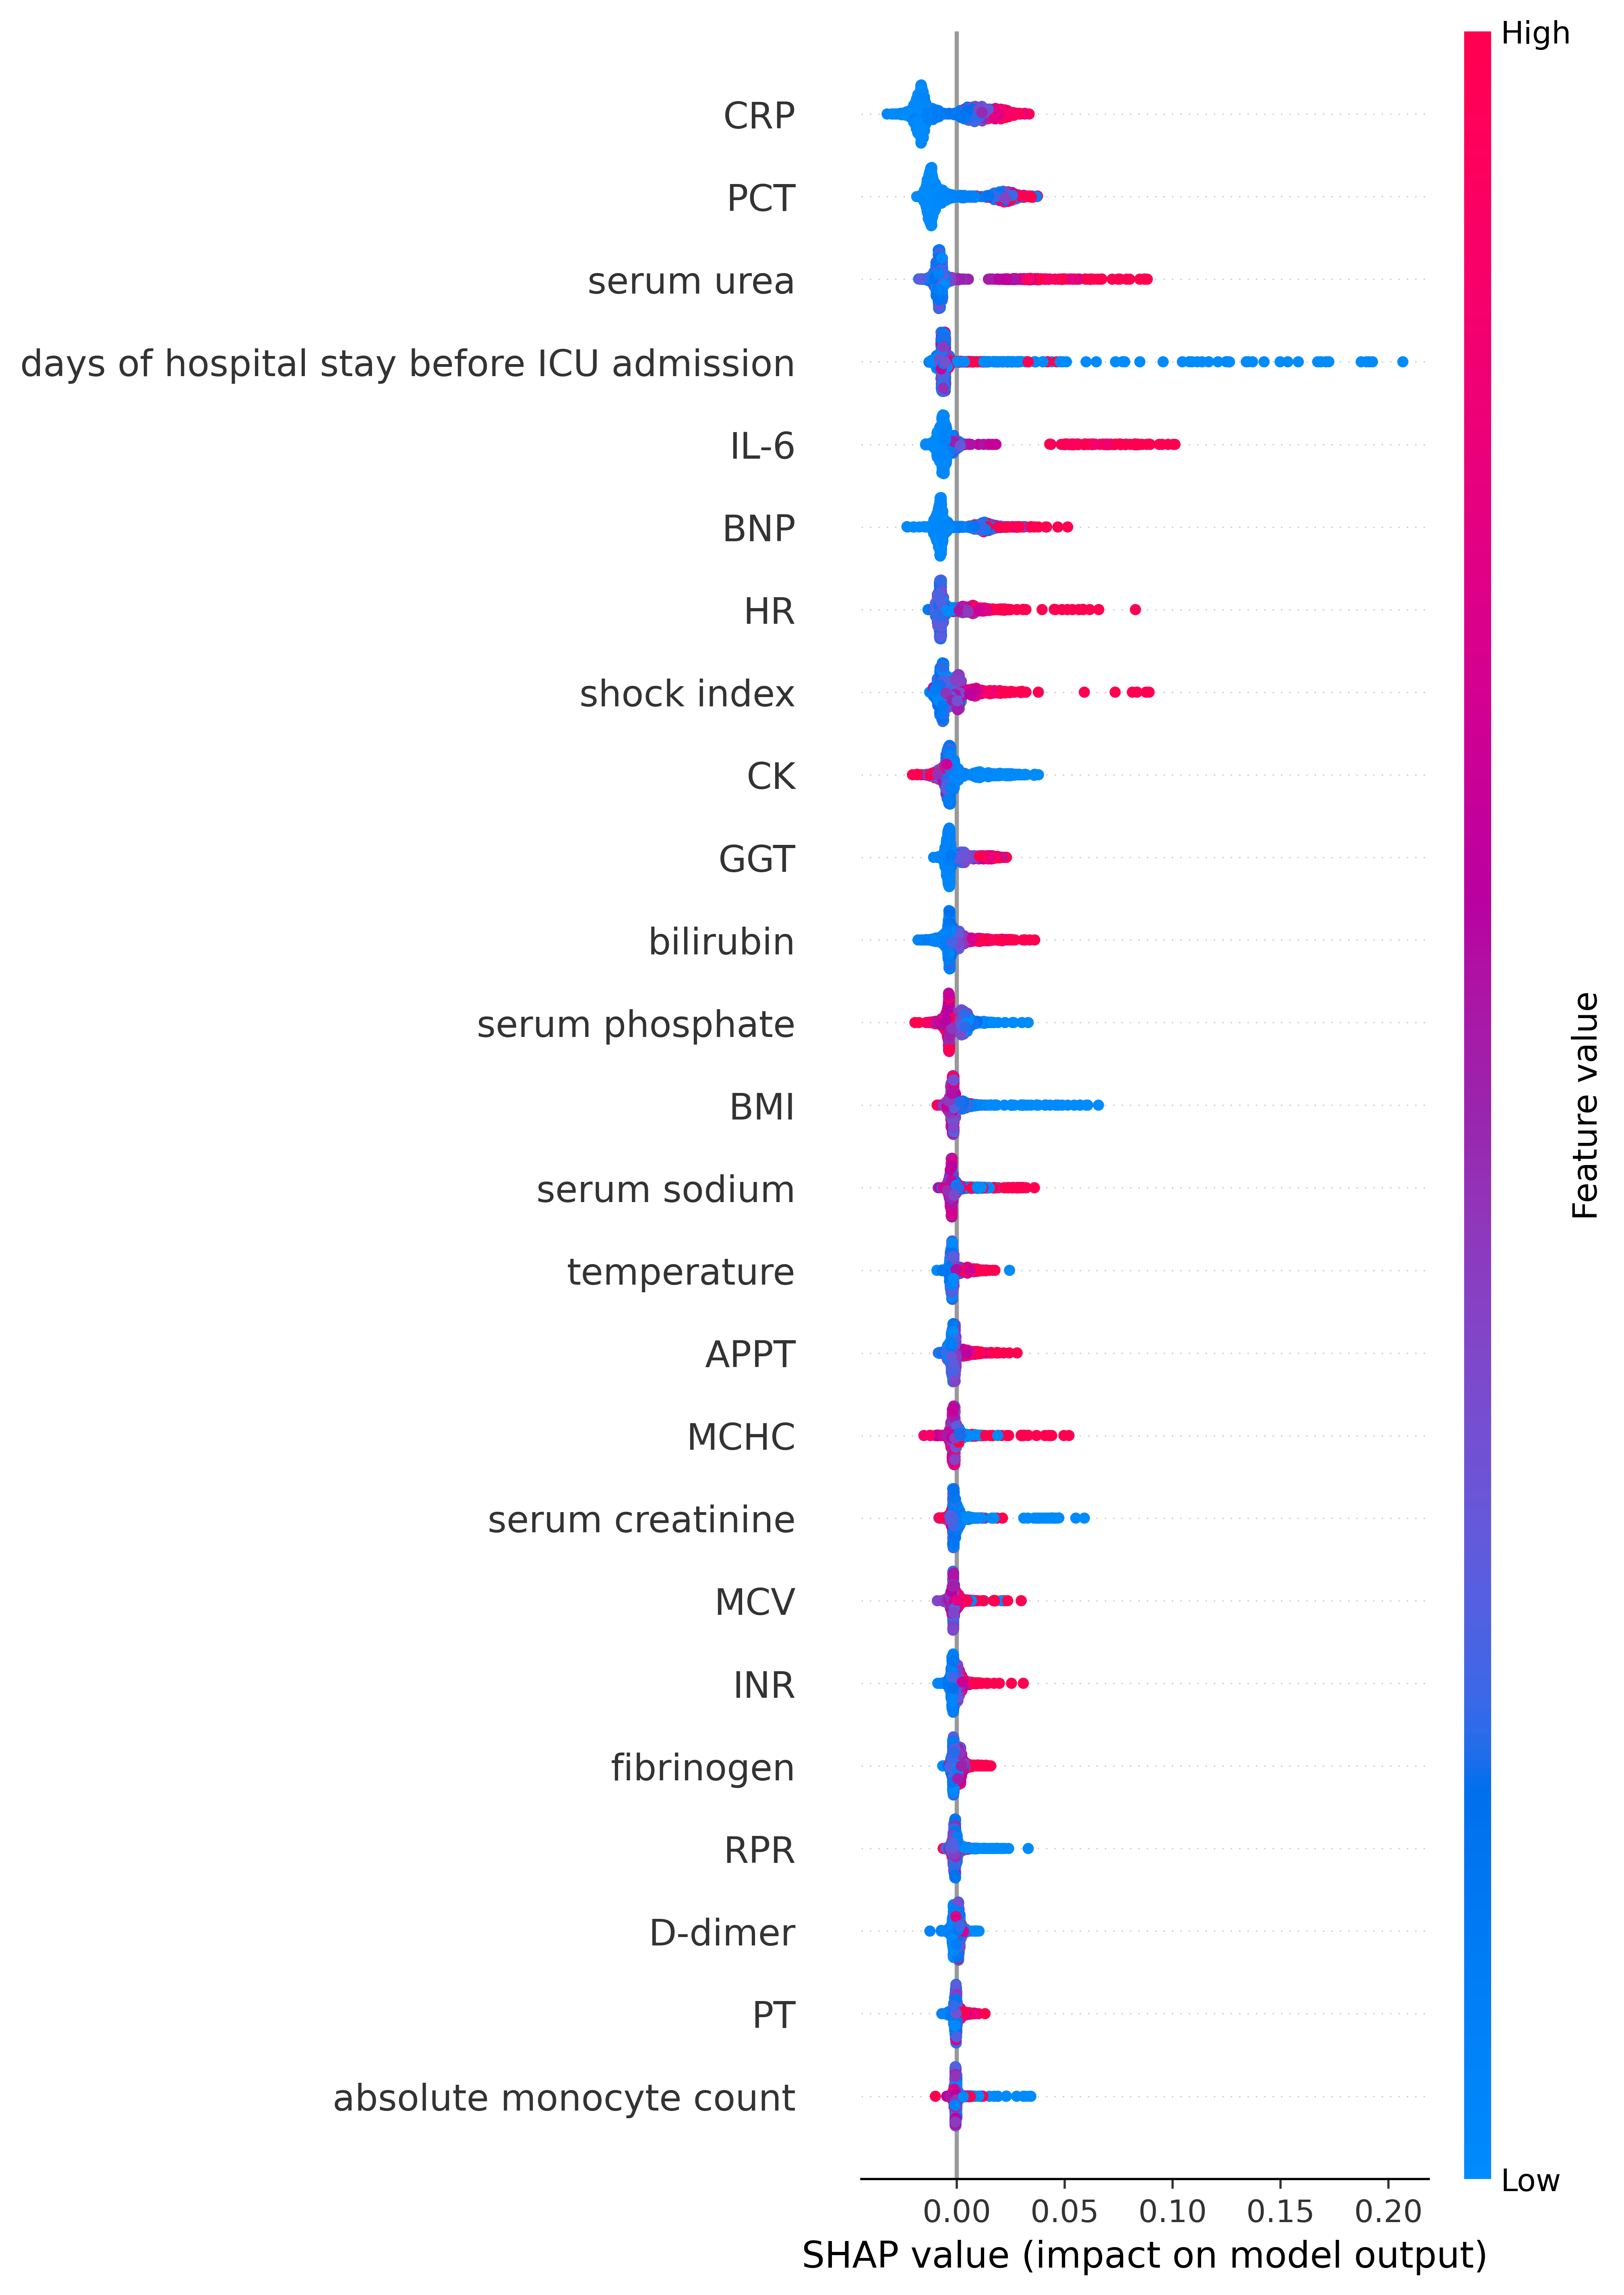

In [114]:
plt.figure(figsize=(12,48),dpi = 500)
# font = {'family' : 'SimHei', 'weight': 'bold', 'size' : '16'}
# plt.rc('font',**font) # 步骤一(设置字体的更多属性)
shap.summary_plot(shap_values_tot[1],features =x_val_tot,
                  feature_names = feature_name_tot_RE,  max_display = 25,
                  plot_type = 'dot',show = False)

#plt.xlabel("x轴")

plt.savefig('results/dot_plot_tot_revise.pdf',format = 'pdf',bbox_inches = 'tight', dpi = 500)

In [55]:
pd.DataFrame(gramtot_predict_dict).to_csv('results/PLAGH_posibility.csv',index = False)

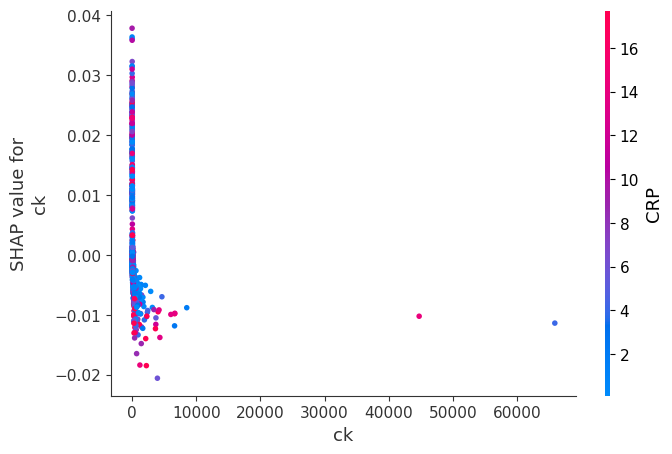

In [56]:
shap.dependence_plot("ck", shap_values_tot[1], x_val_tot, interaction_index= 'CRP')

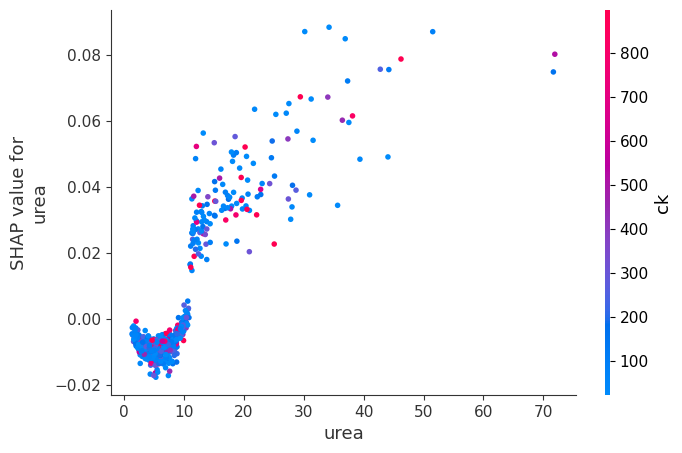

In [57]:
shap.dependence_plot("urea", shap_values_tot[1], x_val_tot, interaction_index= 'ck')

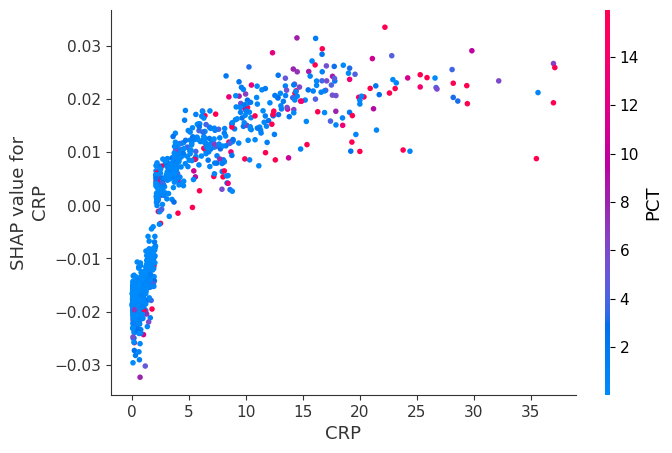

In [58]:
shap.dependence_plot("CRP", shap_values_tot[1], x_val_tot, interaction_index= 'PCT')

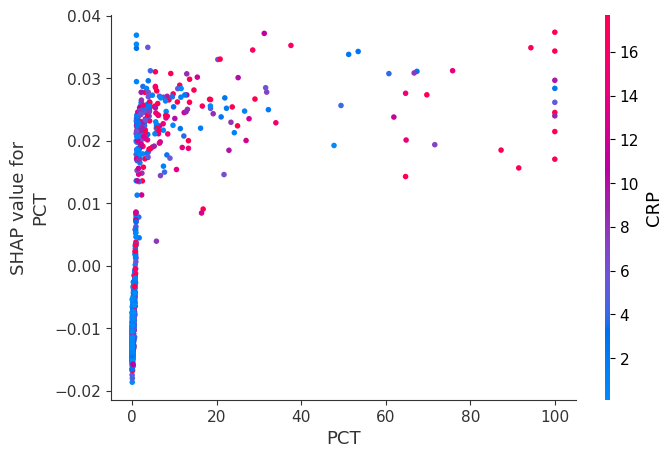

In [59]:
shap.dependence_plot("PCT", shap_values_tot[1], x_val_tot, interaction_index= 'CRP')

In [ ]:
val_df[val_df['stay_chart_included_mdr'] == 1]

,GENDER,AGE,BMI,BODY_WEIGHT,previous_mdrpos_lessthan90d,previous_mdrneg_lessthan90d,icustay_rank,hospstay_seq,los_hosp_beforeicu,myocardial_infarct,...,eosinophil_abs,basophil_abs,lymphocytes_abs,RPR,NLR,shock_index,stay_chart_included_mdr,stay_chart_included_mdr_neg_tot,stay_chart_included_mdr_pos_tot,previous_mdr_90d
8,1,59.63,31.020408,95.0,0,0,1,2,0.158704,0,...,0.05050,0.00000,1.51500,0.158621,5.266667,0.942149,1,1,0,0
9,0,83.10,20.028842,50.0,0,0,1,6,3.883044,0,...,0.04055,0.00811,0.38117,0.071066,19.148936,0.639640,1,1,0,0
22,0,86.10,13.671875,35.0,0,1,8,5,0.001644,1,...,0.08696,0.01087,1.07613,0.168908,8.555556,0.655172,1,1,0,1
23,0,86.24,13.013087,35.0,1,1,9,6,0.005833,0,...,0.07154,0.01022,0.98112,0.197872,8.822917,0.564103,1,1,0,1
24,0,86.34,14.381986,38.0,1,1,14,11,0.002373,1,...,0.05392,0.01348,1.61760,0.163559,6.866667,0.677419,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,1,68.82,25.648918,75.0,0,0,3,14,0.050544,0,...,0.08967,0.05124,1.31943,0.257895,8.252427,0.646617,1,1,0,0
1065,1,67.90,22.230987,62.0,0,0,2,2,2.170116,0,...,0.00000,0.02210,0.77350,0.111486,12.328571,0.851852,1,1,0,0
1073,0,45.16,18.645344,52.0,0,0,1,1,9.421782,0,...,0.00000,0.00000,0.41038,0.279592,5.725352,0.882883,1,1,0,0
1124,1,66.11,29.411765,85.0,0,0,1,1,10.019977,0,...,0.04506,0.06008,0.25534,0.081707,56.882353,0.836066,1,1,0,0


sodium                  128.000000
RPR                       0.163559
creatinine              329.200000
monocytes_abs             0.687480
mcv                      93.200000
INR                       1.260000
mchc                    348.000000
APPT                     55.400000
fibrinogen                4.570000
Temperature              38.000000
shock_index               0.677419
bilirubin                 3.500000
D_dimer                   2.770000
PT                       15.600000
p                         1.070000
gamma_GT                 13.600000
BMI                      14.381986
BNP                   35000.000000
PCT                       0.846000
urea                     27.070000
CRP                      16.696000
ck                       38.000000
IL_6                    137.300000
HR                       84.000000
los_hosp_beforeicu        0.002373
Name: 24, dtype: float64


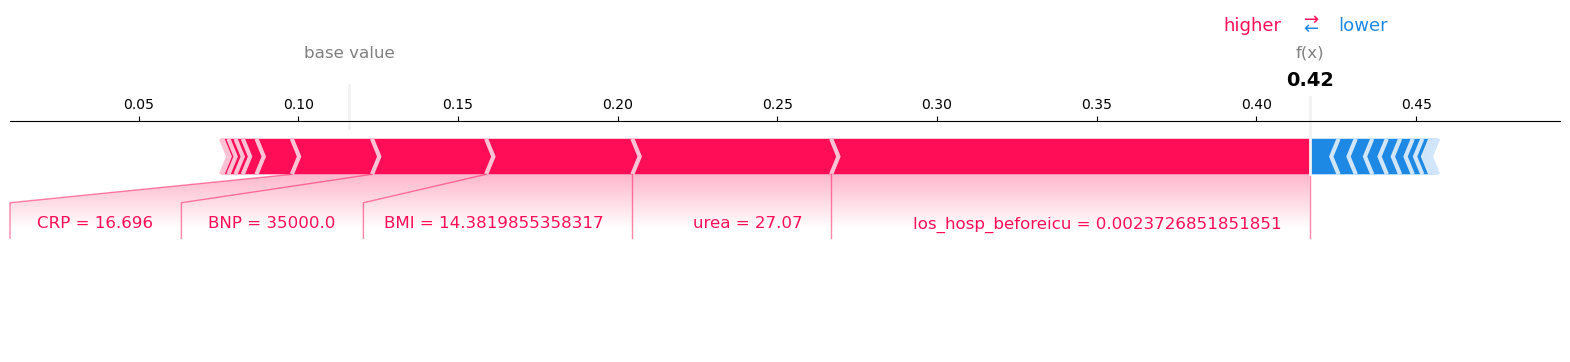

In [72]:
loc_row = 24
print(x_val_tot[x_val_tot.columns].iloc[loc_row,:])
shap.force_plot(explainer_tot.expected_value[1], shap_values_tot[1][loc_row,:],features =x_val_tot.iloc[loc_row,:],matplotlib = True)

sodium                  130.700000
RPR                       0.168908
creatinine              227.600000
monocytes_abs             0.489150
mcv                      98.700000
INR                       2.080000
mchc                    333.000000
APPT                     49.200000
fibrinogen                0.600000
Temperature              37.800000
shock_index               0.655172
bilirubin                 4.900000
D_dimer                   2.890000
PT                       23.100000
p                         1.380000
gamma_GT                 26.400000
BMI                      13.671875
BNP                   25379.000000
PCT                       0.875000
urea                     20.430000
CRP                       4.681000
ck                       25.800000
IL_6                    107.900000
HR                       95.000000
los_hosp_beforeicu        0.001644
Name: 22, dtype: float64


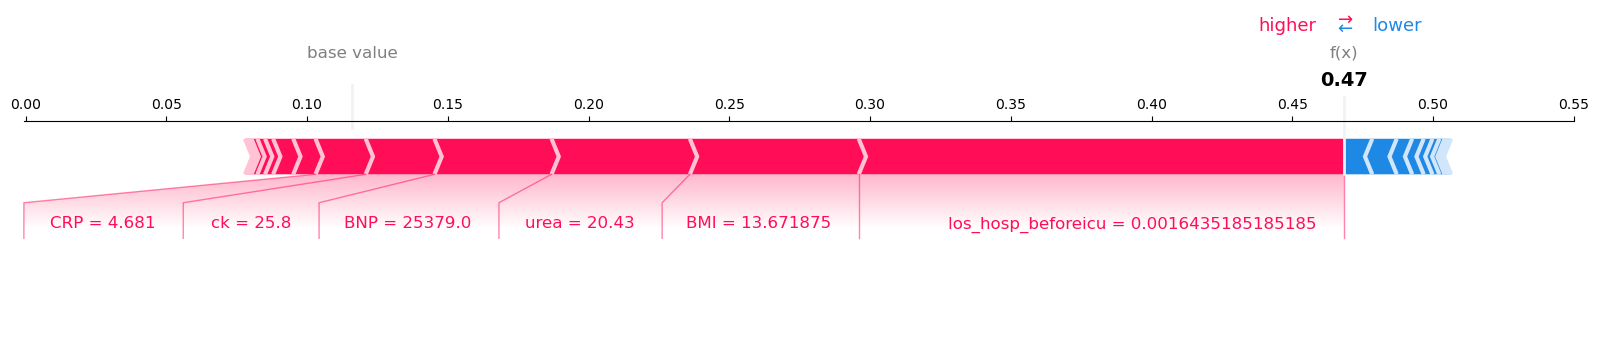

In [66]:
loc_row = 22
print(x_val_tot[x_val_tot.columns].iloc[loc_row,:])
shap.force_plot(explainer_tot.expected_value[1], shap_values_tot[1][loc_row,:],features =x_val_tot.iloc[loc_row,:],matplotlib = True)

sodium                139.300000
RPR                     0.058525
creatinine             84.900000
monocytes_abs           0.375120
mcv                    94.500000
INR                     1.060000
mchc                  329.000000
APPT                   45.900000
fibrinogen              3.430000
Temperature            36.500000
shock_index             0.542636
bilirubin               7.900000
D_dimer                 0.550000
PT                     13.600000
p                       1.300000
gamma_GT               55.200000
BMI                    27.548209
BNP                   126.400000
PCT                     0.064000
urea                    5.470000
CRP                     0.193000
ck                    118.100000
IL_6                   78.350000
HR                     70.000000
los_hosp_beforeicu      5.075278
Name: 0, dtype: float64


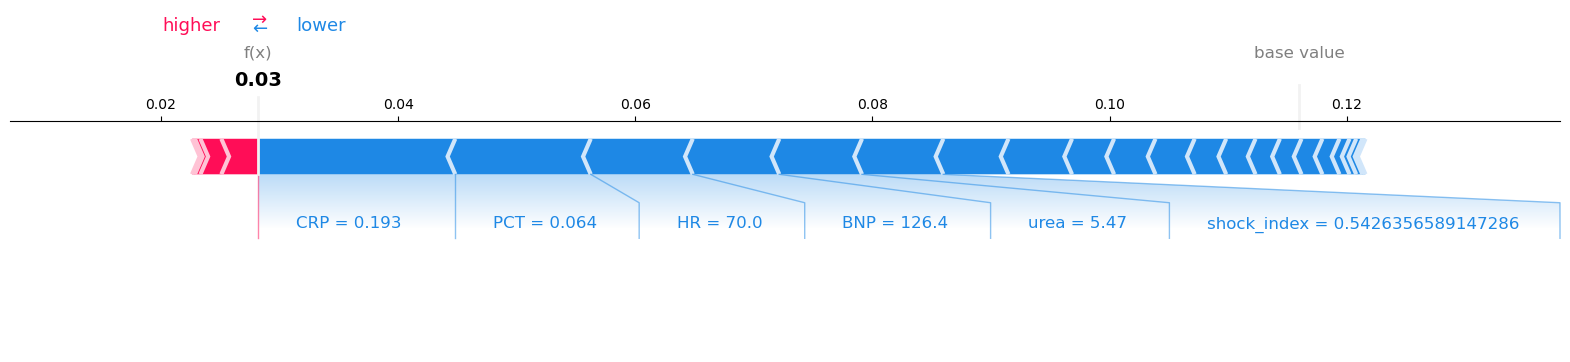

In [74]:
loc_row = 0
print(x_val_tot[x_val_tot.columns].iloc[loc_row,:])
shap.force_plot(explainer_tot.expected_value[1], shap_values_tot[1][loc_row,:],features =x_val_tot.iloc[loc_row,:],matplotlib = True)

## feature importance

In [75]:
import joblib

In [76]:
joblib.dump(gramtot_lr,'lr.pkl')
joblib.dump(gramtot_knn,'knn.pkl')
joblib.dump(gramtot_svc,'svc.pkl')
joblib.dump(gramtot_rf,'rf.pkl')
joblib.dump(gramtot_xgb,'xgb.pkl')
joblib.dump(gramtot_mlp,'mlp.pkl')
joblib.dump(gramtot_ensemble,'ensembler.pkl')

['ensembler.pkl']

In [77]:
models = \
['gramtot_lr',
 'gramtot_knn',
 'gramtot_svc',
 'gramtot_rf',
 'gramtot_xgb',
 'gramtot_mlp',
 'gramtot_ensemble'
]

In [78]:
import re

In [79]:
models_redefined = {re.split('_', i)[1]: i for i in modelsname_all}

In [65]:
model_names = ["lr", "rf", "xgb", "mlp"]

In [66]:
models_redefined = {'lr': gramtot_lr,
 # 'knn': gramtot_knn,
 # 'svc': gramtot_svc,
 'rf': gramtot_rf,
 'xgb': gramtot_xgb,
 'mlp': gramtot_mlp,
 'ensemble': gramtot_ensemble}

In [67]:
# 特征重要性字典
feature_importances = {}

# 提取特征重要性
for name in model_names:
    model = models_redefined[name]
    if name in ["lr"]:
        # 对于逻辑回归和SVC（假设是线性的），使用模型系数
        importance = np.abs(model.coef_[0])
    elif name in ["rf", "xgb"]:
        # 对于随机森林，使用内置的特征重要性
        importance = model.feature_importances_
    elif name == "mlp":
        # 对于MLP，我们将计算第一层权重的绝对值的平均值作为特征重要性（这是一种近似方法）
        importance = np.mean(np.abs(model.coefs_[0]), axis=1)
    feature_importances[name] = importance

# 检查提取的特征重要性
feature_importances.keys()

dict_keys(['lr', 'rf', 'xgb', 'mlp'])

In [85]:
feature_name_tot_RE

['serum sodium',
 'RPR',
 'serum creatinine',
 'absolute monocyte count',
 'MCV',
 'INR',
 'MCHC',
 'APPT',
 'fibrinogen',
 'temperature',
 'shock index',
 'bilirubin',
 'D-dimer',
 'PT',
 'serum phosphate',
 'GGT',
 'BMI',
 'BNP',
 'PCT',
 'serum urea',
 'CRP',
 'CK',
 'IL-6',
 'HR',
 'days of hospital stay before ICU admission']

In [86]:
from sklearn.preprocessing import MinMaxScaler

# 将特征重要性转换为DataFrame
feature_importances_df = pd.DataFrame(feature_importances, index=feature_name_tot_RE)

# 标准化特征重要性
scaler = MinMaxScaler()
feature_importances_normalized = pd.DataFrame(
    scaler.fit_transform(feature_importances_df),
    columns=feature_importances_df.columns,
    index=feature_importances_df.index
)

# 查看标准化后的特征重要性
feature_importances_normalized


,lr,rf,xgb,mlp
serum sodium,0.218886,0.243164,0.318866,0.065003
RPR,0.093348,0.092218,0.176542,0.671276
serum creatinine,0.139491,0.235228,0.194777,0.117024
absolute monocyte count,0.108788,0.122265,0.387179,0.034173
MCV,0.403652,0.207636,0.189152,0.009679
INR,0.105572,0.103990,0.349072,0.087630
MCHC,0.340073,0.119221,0.174977,0.071111
APPT,0.193187,0.117286,0.318352,0.000000
fibrinogen,0.013595,0.083376,0.156811,0.057210
temperature,0.257119,0.153644,0.086056,0.025913


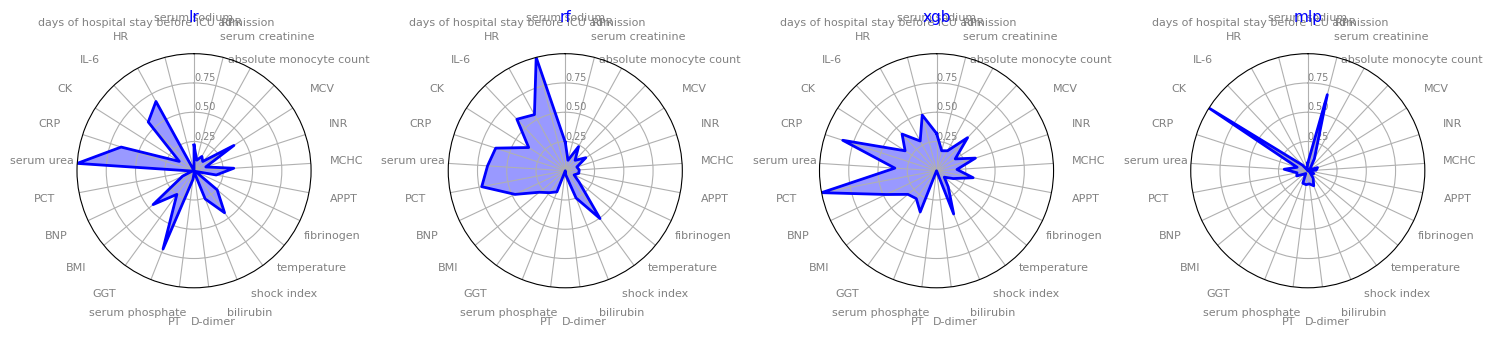

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# 函数：绘制雷达图
def make_spider(row, title, color):
    # 数量的类别
    categories = list(feature_importances_normalized.index)
    N = len(categories)

    # 每个特征重要性之间的角度
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # 绘图
    ax = plt.subplot(1, 4, row+1, polar=True)

    # 第一个轴放在上面
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # 画一个、设置x轴和y轴的位置
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.tick_params(axis='x', which='major', pad=15)

    # 画y轴
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.50, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=7)
    plt.ylim(0,1)

    # 绘制数据
    values = feature_importances_normalized.loc[:, title].values.tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # 添加标题
    plt.title(title, size=11, color=color, y=1.1)

# 创建雷达图
plt.figure(figsize=(15, 5))

# 添加每个模型的特征重要性
for i, model in enumerate(feature_importances_normalized.columns):
    make_spider(i, model, 'b')

plt.tight_layout()
plt.show()


In [88]:
# 函数：绘制雷达图
def make_spider(model, color, ax):
    # 数量的类别
    categories = list(feature_importances_normalized.index)
    N = len(categories)

    # 每个特征重要性之间的角度
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # 绘图
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # 画一个、设置x轴和y轴的位置
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    ax.tick_params(axis='x', which='major', pad=15)

    # 画y轴
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.50, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=7)
    plt.ylim(0,1)

    # 绘制数据
    values = feature_importances_normalized.loc[:, model].values.tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, color=color, alpha=0.4)

# # 创建雷达图
# plt.figure(figsize=(10, 10))
# ax = plt.subplot(111, polar=True)

# # 添加每个模型的特征重要性
# colors = ['blue', 'green', 'red','black']
# for i, model in enumerate(feature_importances_normalized.columns):
#     make_spider(model, colors[i], ax)

# # 添加图例
# plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# plt.show()

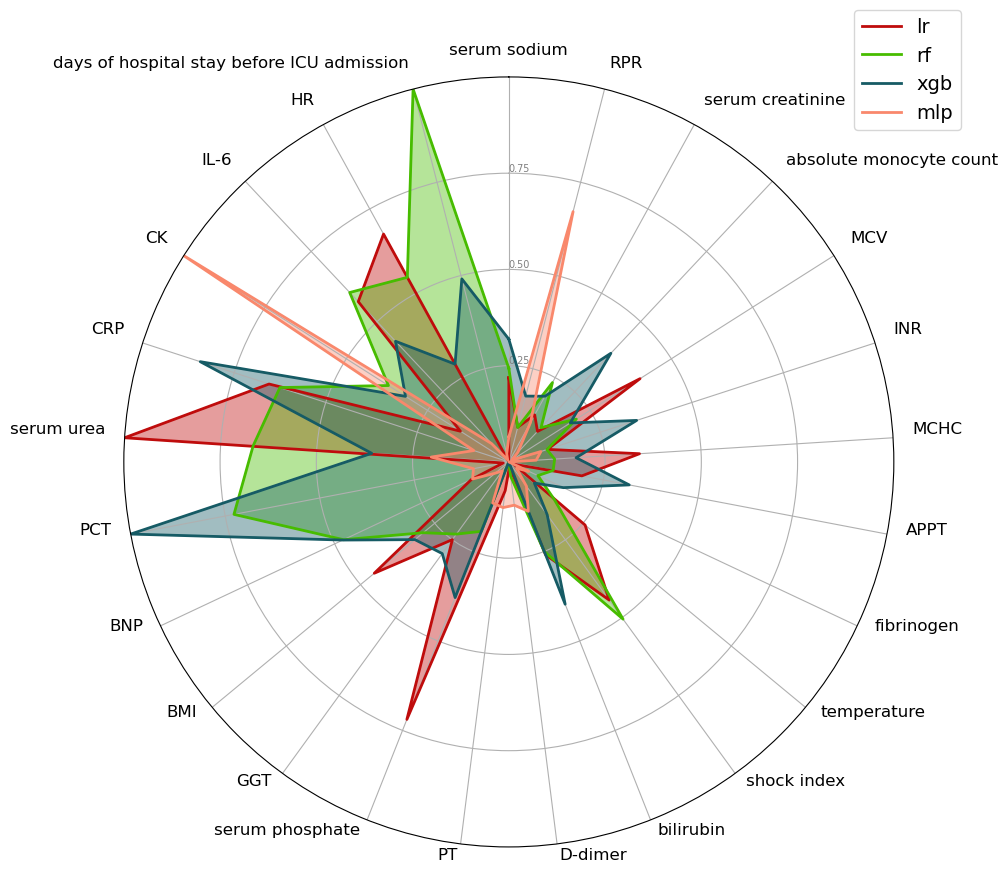

In [89]:
# 重新调整雷达图，保留竖直网格线并确保特征名称位置正确

# 创建雷达图
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
colors =['#bf0c0c','#47bc00','#165b65','#f9886c']

# 添加每个模型的特征重要性
for i, model in enumerate(feature_importances_normalized.columns):
    make_spider(model, colors[i], ax)

# 特征名称的位置调整
# 恢复默认的标签（网格线）
labels = list(feature_importances_normalized.index)
angles = [n / float(len(labels)) * 2 * np.pi for n in range(len(labels))]
angles += angles[:1]  # 完成循环

plt.xticks(angles[:-1], [])  # 移除原有标签文字，保留网格线

# 添加新的特征名称标签
for label, angle in zip(labels, angles[:-1]):
    if angle in [0, np.pi]:
        ha, va = "center", "bottom"
    elif 0 < angle < np.pi:
        ha, va = "left", "bottom"
    elif np.pi < angle < 2*np.pi:
        ha, va = "right", "bottom"
    else: # angle == np.pi
        ha, va = "center", "top"

    ax.text(angle, 1.05, label, size=12, horizontalalignment=ha, verticalalignment=va)

# 添加图例
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1),fontsize=14)
plt.savefig('results/PLAGH_feature_importance_radar_chart.pdf', format='pdf', bbox_inches='tight')

plt.show()

# sensitivity analysis

In [81]:
df_tot = pd.read_csv('mdro_cohort.csv')

In [90]:
def trans_time(t):
    if t == 'None':
        return np.datetime64('NaT')
    elif pd.isna(t):
        return np.datetime64('NaT')
    else:
        return np.datetime64(t)
df_tot.TF_ADMISSION_DATE_TIME = df_tot.TF_ADMISSION_DATE_TIME.apply(trans_time)
df_tot['year'] = df_tot.TF_ADMISSION_DATE_TIME.dt.year

In [92]:
val_df_tot = df_tot[df_tot['year'].isin([2017,2018,2019])]

In [97]:
val_df_tot['monocytes_abs'] = val_df_tot['monocytes'] * val_df_tot['wbc']
val_df_tot['neutrophils_abs'] = val_df_tot['bands'] * val_df_tot['wbc']
val_df_tot['eosinophil_abs'] = val_df_tot['eosinophil'] * val_df_tot['wbc']
val_df_tot['basophil_abs'] = val_df_tot['basophil'] * val_df_tot['wbc']
val_df_tot['lymphocytes_abs'] = val_df_tot['LYN'] * val_df_tot['wbc']
val_df_tot['lymphocytes_abs'] = val_df_tot['lymphocytes_abs'].apply(lambda x:0.0001 if x == 0 else x)

In [98]:
val_df_tot['RPR'] = val_df_tot['rdw']/val_df_tot['platelet']
val_df_tot['NLR'] = val_df_tot['neutrophils_abs']/val_df_tot['lymphocytes_abs']

val_df_tot['SBP'] = val_df_tot['SBP'].apply(lambda x:0.0001 if x == 0 else x)
val_df_tot['shock_index'] = val_df_tot['HR']/val_df_tot['SBP']

In [111]:
val_df_tot['lymphocytes_abs'] = val_df_tot['lymphocytes_abs'].replace(0, 0.001)
val_df_tot['NLR'] = val_df_tot['neutrophils_abs']/val_df_tot['lymphocytes_abs']

In [100]:
val_df_tot['previous_mdr_90d'] = (val_df_tot['previous_mdrpos_lessthan90d'] + val_df_tot['previous_mdrneg_lessthan90d']).apply(lambda x:1 if x>=1 else 0)

In [107]:
val_df_com = val_df_tot[['sodium',
 'RPR',
 'creatinine',
 'monocytes_abs',
 'mcv',
 'INR',
 'mchc',
 'APPT',
 'fibrinogen',
 'Temperature',
 'shock_index',
 'bilirubin',
 'D_dimer',
 'PT',
 'p',
 'gamma_GT',
 'BMI',
 'BNP',
 'PCT',
 'urea',
 'CRP',
 'ck',
 'IL_6',
 'HR',
 'los_hosp_beforeicu','stay_chart_included_mdr'
]]

In [108]:
pd.isna(val_df_com).sum()

sodium                      0
RPR                         1
creatinine                  0
monocytes_abs               0
mcv                         0
INR                         0
mchc                        0
APPT                        0
fibrinogen                  0
Temperature                 0
shock_index                 1
bilirubin                   0
D_dimer                     0
PT                          0
p                           0
gamma_GT                    0
BMI                        83
BNP                         1
PCT                         1
urea                        0
CRP                         0
ck                          0
IL_6                        2
HR                          0
los_hosp_beforeicu          0
stay_chart_included_mdr     0
dtype: int64

In [109]:
val_df_complete = val_df_com.dropna()

In [110]:
val_df_complete.describe()

,sodium,RPR,creatinine,monocytes_abs,mcv,INR,mchc,APPT,fibrinogen,Temperature,...,BMI,BNP,PCT,urea,CRP,ck,IL_6,HR,los_hosp_beforeicu,stay_chart_included_mdr
count,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.00000,1060.000000,1060.000000,1060.000000,...,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000
mean,140.202642,0.095549,94.341321,0.441842,87.732358,1.328000,340.89717,41.658113,3.568604,36.705396,...,24.032000,1201.198019,3.145931,6.696726,3.904203,376.531038,454.111991,82.467925,7.516447,0.105660
std,5.105729,0.107861,97.012988,0.395029,5.805764,0.605596,15.13171,14.666255,1.713578,0.616577,...,4.029739,4114.289185,11.903271,5.951134,5.980812,2501.530239,1045.864076,16.730433,9.203030,0.307548
min,115.200000,0.017100,14.800000,0.007200,63.800000,0.920000,283.00000,21.500000,0.320000,35.200000,...,13.520822,5.000000,0.020000,1.310000,0.000000,11.600000,1.500000,50.000000,0.000104,0.000000
25%,137.700000,0.055368,54.850000,0.173650,84.700000,1.120000,332.00000,35.100000,2.430000,36.300000,...,21.484375,71.575000,0.055000,3.870000,0.256250,65.075000,38.897500,72.000000,2.015648,0.000000
50%,140.250000,0.072481,70.450000,0.356560,87.900000,1.210000,342.00000,39.100000,3.255000,36.600000,...,23.665244,171.000000,0.188000,5.100000,1.257000,120.200000,97.300000,78.000000,5.882541,0.000000
75%,142.900000,0.100699,92.425000,0.572833,91.100000,1.360000,351.00000,43.500000,4.340000,36.900000,...,26.346494,564.650000,0.945500,7.220000,4.624000,253.925000,250.800000,89.000000,9.788148,0.000000
max,169.100000,1.737500,1162.500000,4.977980,110.100000,15.190000,438.00000,180.000000,16.980000,39.500000,...,45.644610,35000.000000,100.000000,71.940000,37.119000,65900.000000,5000.000000,178.000000,124.294363,1.000000


In [111]:
# 载入模型
gramtot_lr = joblib.load('lr.pkl')
gramtot_knn = joblib.load('knn.pkl')
gramtot_svc = joblib.load('svc.pkl')
gramtot_rf = joblib.load('rf.pkl')
gramtot_xgb = joblib.load('xgb.pkl')
gramtot_mlp = joblib.load('mlp.pkl')
gramtot_ensemble = joblib.load('ensembler.pkl')

# 定义模型列表
models = [gramtot_lr, gramtot_knn, gramtot_svc, gramtot_rf, gramtot_xgb, gramtot_mlp, gramtot_ensemble]

# 提取特征
x_ext = val_df_complete.drop(columns=['stay_chart_included_mdr'])  
y_ext = val_df_complete['stay_chart_included_mdr']

# 对数据进行标准化以及预测
predictions = {}
for model in models:
    model_name = type(model).__name__
    if model_name in ['SVC', 'LogisticRegression', 'MLPClassifier', 'KNeighborsClassifier']:
        scaler = MinMaxScaler()
        scaler.fit(dev_df[label_features_dict['stay_chart_included_mdr']])
        x_ext_scaled = pd.DataFrame(scaler.transform(x_ext))
        predict_ext = model.predict_proba(x_ext_scaled)
    else:
        predict_ext = model.predict_proba(x_ext)

    predictions[model_name] = predict_ext

# 输出预测结果
for model_name, prediction in predictions.items():
    print(f"Predictions for {model_name}:")
    print(prediction)

# 如果希望将所有预测结果写入到一个文件，可以考虑以下代码：
# with open("predictions.txt", "w") as file:
#     for model_name, prediction in predictions.items():
#         file.write(f"Predictions for {model_name}:\n")
#         file.write(f"{prediction}\n")

Predictions for LogisticRegression:
[[0.93778844 0.06221156]
 [0.37917612 0.62082388]
 [0.93677921 0.06322079]
 ...
 [0.87375504 0.12624496]
 [0.84508321 0.15491679]
 [0.92095716 0.07904284]]
Predictions for KNeighborsClassifier:
[[1.         0.        ]
 [0.70681778 0.29318222]
 [1.         0.        ]
 ...
 [0.85512773 0.14487227]
 [0.82130218 0.17869782]
 [0.9606303  0.0393697 ]]
Predictions for SVC:
[[0.78312627 0.21687373]
 [0.6954607  0.3045393 ]
 [0.77810869 0.22189131]
 ...
 [0.75160403 0.24839597]
 [0.7544592  0.2455408 ]
 [0.77204224 0.22795776]]
Predictions for RandomForestClassifier:
[[0.97178656 0.02821344]
 [0.76767339 0.23232661]
 [0.97311282 0.02688718]
 ...
 [0.82872292 0.17127708]
 [0.87967695 0.12032305]
 [0.96039908 0.03960092]]
Predictions for XGBClassifier:
[[0.89448905 0.10551094]
 [0.69560784 0.30439216]
 [0.8918654  0.10813465]
 ...
 [0.8039212  0.19607875]
 [0.82397664 0.17602333]
 [0.8938118  0.10618816]]
Predictions for MLPClassifier:
[[0.96079388 0.03920612

In [112]:
comp_val = dict()
for model_name, prediction in predictions.items():
    comp_val[model_name]=prediction[:,1]
    print(model_name)
    print(roc_auc_score(val_df_complete['stay_chart_included_mdr'],prediction[:,1]))
    print('----------------------------------')
comp_val = pd.DataFrame(comp_val)

comp_val = pd.concat([comp_val,val_df_complete['stay_chart_included_mdr'].reset_index(drop = True)],axis = 1)

LogisticRegression
0.7474287974683544
----------------------------------
KNeighborsClassifier
0.6954961573236889
----------------------------------
SVC
0.6830639692585896
----------------------------------
RandomForestClassifier
0.7712194846292948
----------------------------------
XGBClassifier
0.7740826552139843
----------------------------------
MLPClassifier
0.7584105635925257
----------------------------------
StackingClassifier
0.7791308770343579
----------------------------------


In [113]:
comp_val.to_csv('results/PLAGH_posibility_sens_analysis.csv',index = False)

In [149]:
comp_val

,LogisticRegression,KNeighborsClassifier,SVC,RandomForestClassifier,XGBClassifier,MLPClassifier,StackingClassifier,stay_chart_included_mdr
0,0.105944,0.172526,0.233379,0.150351,0.220439,0.125466,0.131396,0
1,0.071303,0.019692,0.231554,0.062998,0.110716,0.048144,0.060768,0
2,0.074185,0.058660,0.231857,0.061756,0.116168,0.055604,0.061954,0
3,0.160984,0.284673,0.315998,0.158530,0.229047,0.476192,0.198266,0
4,0.030390,0.019001,0.232779,0.033139,0.089291,0.012455,0.045839,0
...,...,...,...,...,...,...,...,...
7617,0.070631,0.077060,0.237887,0.099315,0.144456,0.070119,0.079471,0
7618,0.077477,0.152646,0.236206,0.103686,0.144116,0.094436,0.083531,0
7619,0.060268,0.078405,0.228463,0.060444,0.125157,0.055749,0.061852,0
7620,0.041014,0.017291,0.228675,0.039344,0.089786,0.028757,0.048670,0


In [117]:
#补充f1_score

import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix, f1_score

# Assuming `confidence_interval_new` is a predefined function

fpr, tpr, thresholds = roc_curve(comp_val['stay_chart_included_mdr'], comp_val['StackingClassifier'])

cutoff_l = []
num_l = []
acc_l = []
sens_l = []
spec_l = []
ppv_l = []
npv_l = []
f1_l = []

for i in thresholds:
    test = comp_val[['stay_chart_included_mdr', 'StackingClassifier']]
    test['predict'] = (test['StackingClassifier'] > i).apply(int)
    cm = confusion_matrix(test['stay_chart_included_mdr'], test['predict'])
    num = cm[0][1] + cm[1][1]
    acc_str, sens_str, spec_str, ppv_str, npv_str = confidence_interval_new(cm)

    # Calculate F1-score
    f1 = f1_score(test['stay_chart_included_mdr'], test['predict'])

    cutoff_l.append(i)
    num_l.append(num)
    acc_l.append(acc_str)
    sens_l.append(sens_str)
    spec_l.append(spec_str)
    ppv_l.append(ppv_str)
    npv_l.append(npv_str)
    f1_l.append(f1)

all_cutoff = pd.DataFrame({'截断值': cutoff_l, '数量': num_l, '准确率 (%)': acc_l, '灵敏度 (%)': sens_l,
                           '特异度 (%)': spec_l, '阳性预告值 (%)': ppv_l, '阴性预告值 (%)': npv_l, 'F1-score': f1_l})

num_stard = []
t = 0
for i in range(11):
    g = 1205 / 11
    t = g * i
    num_stard.append(t)

q_find = []
for i in num_stard:
    aa = []
    bb = []

    for j in all_cutoff['数量']:
        de = abs(i - j)
        aa.append(j)
        bb.append(de)

    find_m = bb.index(min(bb))
    q_find.append(aa[find_m])

result = all_cutoff[all_cutoff['数量'].isin(list(set(q_find)))].sort_values(by='截断值').reset_index(drop=True).head(10)
print(result)

        截断值    数量 准确率 (%) 灵敏度 (%) 特异度 (%) 阳性预告值 (%) 阴性预告值 (%)  F1-score
0  0.052368  1059   10.66   100.0    0.11     10.58     100.0  0.191289
1  0.054678  1006   15.47   99.11    5.59     11.03     98.15  0.198569
2  0.056675   881    26.7   96.43   18.46     12.26     97.77  0.217523
3  0.059144   753   38.02   92.86   31.54     13.81     97.39  0.240462
4  0.062794   660   45.85   88.39   40.82      15.0     96.75  0.256477
5  0.068382   544   55.66   83.04   52.43      17.1     96.32  0.283537
6  0.073162   455    63.3   79.46   61.39     19.56      96.2  0.313933
7  0.083837   327   73.68   71.43   73.95     24.46     95.63  0.364465
8  0.107663   218   80.75   56.25   83.65      28.9     94.18  0.381818
9  0.149032   110   86.04   33.04    92.3     33.64     92.11  0.333333


In [118]:
result

,截断值,数量,准确率 (%),灵敏度 (%),特异度 (%),阳性预告值 (%),阴性预告值 (%),F1-score
0,0.052368,1059,10.66,100.0,0.11,10.58,100.0,0.191289
1,0.054678,1006,15.47,99.11,5.59,11.03,98.15,0.198569
2,0.056675,881,26.7,96.43,18.46,12.26,97.77,0.217523
3,0.059144,753,38.02,92.86,31.54,13.81,97.39,0.240462
4,0.062794,660,45.85,88.39,40.82,15.0,96.75,0.256477
5,0.068382,544,55.66,83.04,52.43,17.1,96.32,0.283537
6,0.073162,455,63.3,79.46,61.39,19.56,96.2,0.313933
7,0.083837,327,73.68,71.43,73.95,24.46,95.63,0.364465
8,0.107663,218,80.75,56.25,83.65,28.9,94.18,0.381818
9,0.149032,110,86.04,33.04,92.3,33.64,92.11,0.333333


In [120]:
# #补充f1_score

# import pandas as pd
# from sklearn.metrics import roc_curve, confusion_matrix, f1_score

# # Assuming `confidence_interval_new` is a predefined function

# fpr, tpr, thresholds = roc_curve(comp_val['stay_chart_included_mdr'], comp_val['RandomForestClassifier'])

# cutoff_l = []
# num_l = []
# acc_l = []
# sens_l = []
# spec_l = []
# ppv_l = []
# npv_l = []
# f1_l = []

# for i in thresholds:
#     test = comp_val[['stay_chart_included_mdr', 'RandomForestClassifier']]
#     test['predict'] = (test['RandomForestClassifier'] > i).apply(int)
#     cm = confusion_matrix(test['stay_chart_included_mdr'], test['predict'])
#     num = cm[0][1] + cm[1][1]
#     acc_str, sens_str, spec_str, ppv_str, npv_str = confidence_interval_new(cm)

#     # Calculate F1-score
#     f1 = f1_score(test['stay_chart_included_mdr'], test['predict'])

#     cutoff_l.append(i)
#     num_l.append(num)
#     acc_l.append(acc_str)
#     sens_l.append(sens_str)
#     spec_l.append(spec_str)
#     ppv_l.append(ppv_str)
#     npv_l.append(npv_str)
#     f1_l.append(f1)

# all_cutoff = pd.DataFrame({'截断值': cutoff_l, '数量': num_l, '准确率 (%)': acc_l, '灵敏度 (%)': sens_l,
#                            '特异度 (%)': spec_l, '阳性预告值 (%)': ppv_l, '阴性预告值 (%)': npv_l, 'F1-score': f1_l})

# num_stard = []
# t = 0
# for i in range(11):
#     g = 1205 / 11
#     t = g * i
#     num_stard.append(t)

# q_find = []
# for i in num_stard:
#     aa = []
#     bb = []

#     for j in all_cutoff['数量']:
#         de = abs(i - j)
#         aa.append(j)
#         bb.append(de)

#     find_m = bb.index(min(bb))
#     q_find.append(aa[find_m])

# result = all_cutoff[all_cutoff['数量'].isin(list(set(q_find)))].sort_values(by='截断值').reset_index(drop=True).head(10)
# result